## Imports

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# This example imports functions from the DemoReadSGLXData module to read
# digital data. The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq digital channels.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
from scipy import stats
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter, welch
from scipy.stats import linregress, spearmanr, kendalltau, pearsonr, circstd
from statsmodels.stats.multitest import multipletests
import scipy.stats as sstat

from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from datetime import datetime
from scipy.io import savemat, loadmat
from sklearn.manifold import Isomap
import itertools
import mat73

from matplotlib_venn import venn2, venn3
# load pickle module
import dill as pickle
import time, os, math, sys
from joblib import Parallel, delayed
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']  

# for publication quality plots
def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple'  ],5)):
    sns.set_style("white")
    sns.set_palette('pastel')
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5, 'figure.facecolor': 'white'}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
    'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
    #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
    'axes.linewidth':2.5, 'lines.linewidth': 2.5,
    'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

#set_pub_bargraphs()
set_pub_plots()
sns.set_context('poster')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



In [7]:
good_rec_shanks = [ 'MC022_20220627', 'MC022_20220628', 'MC022_20220629', 'MC022_20220718',
                        'JA179_20220802', 'JA179_20220804', 'JA179_20220805',  
                        'JA180_20220809', 'JA180_20220810', 'JA180_20220811', 'JA180_20220819', 
                        'JA181_20220809', 'JA181_20220812', 'JA181_20220817', 
                        'JA178_20220818', 'JA178_20220819', 'JA178_20220823',
                        'MC038_20220829', 'MC038_20220830',
                        'JA178_20220906', 'JA178_20220907', 'JA178_20220908', 'JA178_20220909']

d_good_shanks = {
    'JA178_left': [2], 'JA178_right': [2], 
    'JA179_left': [2, 3],
    'JA180_left': [2, 3],
    'JA181_left': [3], 
    'MC022_left': [1, 2],
    'MC038_left': [3]
}

vis_rec_id = ['20220627_MC022_lADN_red_H2_VR1_TS7-HF',  '20220627_MC022_lADN_red_H2_VR1_TS7-VIS',
       '20220628_MC022_lADN_red_H2_VR1_TS6-HF', '20220628_MC022_lADN_red_H2_VR1_TS7-VIS',
       '20220629_MC022_lADN_red_H2_VR1_TS6-HF', '20220629_MC022_lADN_red_H2_VR1_TS6-VIS',
       '20220908_JA178_rADN_yel_H2_VR1_TS6-HF', '20220908_JA178_rADN_yel_H2_VR1_TS6-VIS',
       '20220909_JA178_rADN_yel_H2_VR1_TS6-HF', '20220909_JA178_rADN_yel_H2_VR1_TS6-VIS']

## Functions

In [1]:
def get_recinfo_fname(fn):
    
    dts = fn.split('_')[0]
    mouse_id = fn.split('_')[1]
    hem = fn.split('_')[2]
    hstripe = fn.split('_')[4]
    cond = fn.split('_')[6]
    rec_session = mouse_id + '_' + dts
    
    return dts, mouse_id, hem, hstripe, cond, rec_session

def smooth_interp_yaw(yaw, window_length = 11, polyorder = 1):
    yaw_rad = np.deg2rad(yaw)
    yaw_rad[~np.isnan(yaw_rad)] = np.unwrap(yaw_rad[~np.isnan(yaw_rad)])
    nans, nanx = nan_helper(yaw_rad)
    yaw_rad[nans] = np.interp(nanx(nans), nanx(~nans), yaw_rad[~nans])
    yaw_intrp = np.rad2deg(yaw_rad)
    yaw_sm = savgol_filter(yaw_intrp, window_length=window_length, polyorder=polyorder)
    yaw_sm = yaw_sm % 360
    return yaw_sm

def get_yaw_speed_rec(rec, d_data):
    """
    get behavior from dict
    smoothsed yaw in deg, speed in cm/s
    """
    if 'HF' in rec:
        yaw = d_data[rec]['unity']['head_dir'].values
        yaw_sm = smooth_interp_yaw(yaw, 31, 2)
        lin_speed = d_data[rec]['unity']['speed'].values*100
        lin_speed_sm = savgol_filter(lin_speed, window_length=25, polyorder=2)
    elif 'L1' in rec or 'D1' in rec:
        # speed in cm/s
        yaw = d_data[rec]['unity']['hd'].values
        yaw_sm = smooth_interp_yaw(yaw, 31, 2)
        lin_speed = d_data[rec]['unity']['tail_speed'].values
        lin_speed_sm = savgol_filter(lin_speed, window_length=25, polyorder=2)
    else:
        yaw_sm = d_data[rec]['unity']['RotY'].values
#         yaw_sm = smooth_interp_yaw(yaw_sm, 31, 2)
        lin_speed = d_data[rec]['unity']['speed'].values*100
        lin_speed_sm = savgol_filter(lin_speed, window_length=25, polyorder=2)
        
    return yaw_sm, lin_speed_sm

In [2]:
def get_stat_run_epochs(speed, window_size = 25, speed_thr = 4):
    speed = abs(speed)
    speed = speed[:speed.size//window_size*window_size]
    speed_bin_mean = np.nanmean(speed.reshape(-1, window_size), 1)  
    speed_idx = np.concatenate([np.arange(pair[0]*window_size, pair[0]*window_size + window_size) for 
                            pair in enumerate(speed_bin_mean) if pair[1] > speed_thr])[:-10]
    stat_idx = np.concatenate([np.arange(pair[0]*window_size, pair[0]*window_size + window_size) for 
                            pair in enumerate(speed_bin_mean) if pair[1] <= speed_thr])[:-10]
    return stat_idx, speed_idx




In [3]:
def adjust_offset_emb(y, dec):
    yerr = ((y[:] - dec[:]) + 180)%360 - 180
    offset = np.mean((yerr))
    # adjust offset
    dec = (dec + offset) % 360 
    return dec

def decode_az_isomap(x, y, yaw):
    dec_err = 0
    yaw_dec = 0
    yaw_dec_xy = np.arctan2(x, y)*180/np.pi
    yaw_dec_yx = np.arctan2(y, x)*180/np.pi
        
    yaw_dec_xy1 = yaw_dec_xy + 180
    yaw_dec_yx1 = yaw_dec_yx + 180
    
    yaw_dec_xy2 = yaw_dec_xy
    yaw_dec_xy2[yaw_dec_xy2 < 0] = yaw_dec_xy2[yaw_dec_xy2 < 0] + 360
    
    yaw_dec_yx2 = yaw_dec_yx
    yaw_dec_yx2[yaw_dec_yx2 < 0] = yaw_dec_yx2[yaw_dec_yx2 < 0] + 360
    
    yaw_dec_xy1 = adjust_offset_emb(yaw, yaw_dec_xy1)
    yaw_dec_xy2 = adjust_offset_emb(yaw, yaw_dec_xy2)
    yaw_dec_yx1 = adjust_offset_emb(yaw, yaw_dec_yx1)
    yaw_dec_yx2 = adjust_offset_emb(yaw, yaw_dec_yx2)
    
    dec_err1 = np.mean(abs(((yaw[:] - yaw_dec_xy1[:]) + 180)%360 - 180))
    dec_err2 = np.mean(abs(((yaw[:] - yaw_dec_xy2[:]) + 180)%360 - 180))
    dec_err3 = np.mean(abs(((yaw[:] - yaw_dec_yx1[:]) + 180)%360 - 180))
    dec_err4 = np.mean(abs(((yaw[:] - yaw_dec_yx2[:]) + 180)%360 - 180))
    
    dec_arr = np.array((dec_err1, dec_err2, dec_err3, dec_err4))
    idx = dec_arr.argmin()
    if idx == 0:
        yaw_dec = yaw_dec_xy1
    elif idx == 1:
        yaw_dec = yaw_dec_xy2
    elif idx == 2:
        yaw_dec = yaw_dec_yx1
    elif idx == 3:
        yaw_dec = yaw_dec_yx2
        
    return yaw_dec, dec_arr[idx], idx

In [4]:
def compute_ringness(inp):
 
    dist_tmp = []
    vis_dist = []
    x = inp[:,0]
    y = inp[:,1]
    n_samples10 = x.size//4
    centroid = np.mean(inp, axis = 0)
    
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    viscenter = (xmin + xmax)/2, (ymin + ymax)/2
    
    for idx in range(inp.shape[0]):
#         dist_tmp.append(math.dist(centroid[:],data[idx,:]))
        dist_tmp.append(np.linalg.norm(centroid-inp[idx, :])) 
        vis_dist.append(np.linalg.norm(viscenter-inp[idx, :]))
        
#     dist_tmp.sort(reverse = True)
    vis_dist_out = vis_dist.copy()
    vis_dist.sort()
    bot10 = vis_dist[:n_samples10]
    vis_dist.sort(reverse = True)
    top10 = vis_dist[:n_samples10]
    
    radius = np.mean(dist_tmp[:])
    vis_radius = np.mean(vis_dist[:])
    ringness = np.mean(bot10)/np.mean(top10)*radius
#     for idx in range(data.shape[0]):
#         ringness.append(np.abs(np.sqrt((data[idx,0]-centroid[0])**2+(data[idx,1]-centroid[1])**2)-radius))
    
    return radius, centroid, ringness, vis_dist_out

def compute_radius(x, y):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    viscenter = (xmin + xmax)/2, (ymin + ymax)/2
    
    vis_r = np.sqrt((x - viscenter[0])**2 + (y - viscenter[1])**2)
    r = np.sqrt(x**2 + y**2)
    return r, vis_r

In [5]:
def compute_betti(isomap_emb):
    H1_rates = isomap_emb
    
    if len(H1_rates) > 10000:
        idx = np.random.choice(np.arange(len(H1_rates)), 10000, replace=False)
        H1_rates = H1_rates[idx]
        
    barcodes = tda(H1_rates, maxdim=1, coeff=2)['dgms']
    h0 = barcodes[0]
    h1 = barcodes[1]

    # H2. Need to subsample points for computational tractability if 
    # number of points is large (can go higher but very slow)
    if len(H1_rates) > 1500:
        idx = np.random.choice(np.arange(len(H1_rates)), 1500, replace=False)
        H2_rates = H1_rates[idx]
    else:
        H2_rates = H1_rates
    barcodes = tda(H2_rates, maxdim=2, coeff=2)['dgms']
    h2 = barcodes[2]
    return h0, h1, h2

def get_long_bettibars(h0, h1, h2):
    h0[~np.isfinite(h0)] = 40
    plot_prcnt = [95, 90, 50] # order is h0, h1, h2
    to_plot = []
    for curr_h, cutoff in zip([h0, h1, h2], plot_prcnt):
#         print(curr_h.shape)
        top_indices  = np.argsort(curr_h[:, 1] - curr_h[:, 0])[-20:]
#         if curr_h.shape[0] < 100:
        plot_h = curr_h
#         else:
#             bar_lens = curr_h[:,1] - curr_h[:,0]
#             plot_h = curr_h[bar_lens > np.percentile(bar_lens, cutoff)]
        if cutoff == plot_prcnt[1]: 
            long_bar = sorted(curr_h[:, 1] - curr_h[:, 0])[-1]
        to_plot.append(curr_h[top_indices])
        
    return to_plot, long_bar

In [6]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

a = np.array([0, 47, 48, 49, 50, 97, 98, 99])
b = consecutive(a)

def ang_diff(a1, a2):
    a1 = np.array(a1)
    a2 = np.array(a2)
    return 180 - abs(abs(a1 - a2) - 180)

ang_diff(300, 45)

def compute_dYaw(yaw):

    dYaw = np.gradient(yaw)            
    idx_pos = np.where((dYaw > 180))[0]
    idx_neg = np.where((dYaw < -180))[0]

    dYaw[idx_pos] = dYaw[idx_pos] - 360
    dYaw[idx_neg] = dYaw[idx_neg] + 360
    
#     deltaYaw_filt = savgol_filter(dYaw, window_length=11, polyorder=2)
    # max 250 deg/s
    dYaw[abs(dYaw) > 5] = 0

    return dYaw

In [35]:
def test_xcorr_significance(speed, radius, n_shuffles=500, fs=10, to_plot = False):
    """
    Test if cross-correlation peak between speed and radius is statistically significant.
    Includes visualization of both the cross-correlation function and the permutation test.
    
    Parameters:
    speed, radius - The two time series to correlate
    n_shuffles - Number of shuffles for null distribution
    fs - Sampling frequency in Hz
    
    Returns:
    is_significant - Boolean indicating if peak is significant (p < 0.05)
    p_value - Empirical p-value
    lag_seconds - Lag at peak in seconds
    """
    # Function to compute maximum cross-correlation
    def compute_xcorr_peak(a, b):
        # Mean-center and compute cross-correlation
        a_centered = a - np.mean(a)
        b_centered = b - np.mean(b)
        xcorr = np.correlate(a_centered, b_centered, mode='full')
        return np.max(np.abs(xcorr))
    
    # Compute actual cross-correlation
    speed_centered = speed - np.mean(speed)
    radius_centered = radius - np.mean(radius)
    xcorr_actual = np.correlate(speed_centered, radius_centered, mode='full')
    actual_peak = np.max(np.abs(xcorr_actual))
    
    # Find lag at peak
    peak_idx = np.argmax(np.abs(xcorr_actual))
    lag = peak_idx - (len(speed) - 1)
    lag_seconds = lag / fs
    
    # Perform shuffling test
    shuffle_peaks = np.empty(n_shuffles)
    for i in range(n_shuffles):
        # Randomly shuffle the radius signal
        radius_shuffled = np.random.permutation(radius)
        shuffle_peaks[i] = compute_xcorr_peak(speed, radius_shuffled)
    
    # Compute empirical p-value
    p_value = np.mean(shuffle_peaks >= actual_peak)
    is_significant = p_value < 0.05
    if to_plot == True:
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
        
        # Plot 1: Cross-correlation function
        # Calculate lag axis in seconds
        lags = np.arange(-len(speed)+1, len(speed))
        lags_seconds = lags / fs
        
        # Plot cross-correlation
        ax1.plot(lags_seconds, xcorr_actual, 'b-')
        ax1.axvline(x=0, color='k', linestyle='--', label='Zero Lag')
        ax1.axvline(x=lag_seconds, color='r', linestyle='--', 
                    label=f'Peak Lag: {lag_seconds:.3f}s')
        
        # Highlighting
        if is_significant:
            highlight_color = 'lightgreen'
            highlight_label = 'Significant (p<0.05)'
        else:
            highlight_color = 'lightsalmon'
            highlight_label = 'Not Significant'
            
        # Add shaded background to indicate significance
        ax1.axvspan(lag_seconds-0.05, lag_seconds+0.05, color=highlight_color, alpha=0.3, label=highlight_label)
        
        ax1.set_xlabel('Lag (seconds)')
        ax1.set_ylabel('Cross-correlation')
        ax1.set_title('Cross-correlation Function')
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Permutation test results
        ax2.hist(shuffle_peaks, bins=30, alpha=0.7, color='gray', label='Null distribution')
        ax2.axvline(x=actual_peak, color='red', linestyle='--', 
                    label=f'Observed peak (p={p_value:.3f})')
        
        # Add significance threshold
        threshold = np.percentile(shuffle_peaks, 95)
        ax2.axvline(x=threshold, color='blue', linestyle=':', 
                    label='Significance threshold (p=0.05)')
        
        ax2.set_xlabel('Peak Cross-Correlation')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Permutation Test Results')
        ax2.legend(loc='upper right')
        
        # Add overall title
        plt.suptitle(f'Cross-Correlation Analysis (Lag: {lag_seconds:.3f}s, p={p_value:.3f})', 
                    fontsize=14)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Make room for suptitle
    
    return is_significant, p_value, lag_seconds

## Load data

In [8]:
path = r'/Users/alex/Library/CloudStorage/GoogleDrive-apak@nu.edu.kz/My Drive/SNL @NU/Papers/ADN HD VR-Hfree paper/Data analysis/Data/VR_processed_data/d_emb_ang.p'
# with open(path, 'rb') as handle:
#     d_emb = pickle.load(handle)
d_emb_ang = pd.read_pickle(path)
d_emb_ang.keys()

dict_keys(['20220818_JA178_lADN_red_H2_VR1_TS6-HF', '20220819_JA178_lADN_red_H2_VR1_TS6-HF', '20220819_JA178_lADN_red_H2_VR1_TS7-HF', '20220823_JA178_lADN_red_H2_VR1_TS6-HF', '20220823_JA178_lADN_red_H2_VR1_TS7-HF', '20220906_JA178_rADN_yel_H2_VR1_TS6-HF', '20220907_JA178_rADN_yel_H2_VR1_TS6-HF', '20220907_JA178_rADN_yel_H2_VR1_TS7-HF', '20220908_JA178_rADN_yel_H2_VR1_TS6-HF', '20220909_JA178_rADN_yel_H2_VR1_TS6-HF', '20220802_JA179_lADN_red_H2_VR1_TS6-HF', '20220802_JA179_lADN_red_H2_VR1_TS7-HF', '20220804_JA179_lADN_red_H2_VR1_TS6-HF', '20220804_JA179_lADN_red_H2_VR1_TS7-HF', '20220805_JA179_lADN_red_H2_VR1_TS6-HF', '20220805_JA179_lADN_red_H2_VR1_TS7-HF', '20220809_JA180_lADN_red_H2_VR1_TS6-HF', '20220809_JA180_lADN_red_H2_VR1_TS7-HF', '20220810_JA180_lADN_red_H2_VR1_TS6-HF', '20220810_JA180_lADN_red_H2_VR1_TS7-HF', '20220811_JA180_lADN_red_H2_VR1_TS6-HF', '20220811_JA180_lADN_red_H2_VR1_TS7-HF', '20220819_JA180_lADN_red_H2_VR1_TS6-HF', '20220819_JA180_lADN_red_H2_VR1_TS7-HF', '2022

In [17]:
path = r'/Users/alex/Library/CloudStorage/GoogleDrive-apak@nu.edu.kz/My Drive/SNL @NU/Papers/ADN HD VR-Hfree paper/Data analysis/Data/VR_processed_data/d_emb5.p'
# with open(path, 'rb') as handle:
#     d_emb = pickle.load(handle)
d_emb = pd.read_pickle(path)
d_emb.keys()

dict_keys(['20220818_JA178_lADN_red_H2_R_D1', '20220818_JA178_lADN_red_H2_R_L1', '20220819_JA178_lADN_red_H2_R_D1', '20220819_JA178_lADN_red_H2_R_L1', '20220823_JA178_lADN_red_H2_R_D1', '20220823_JA178_lADN_red_H2_R_L1', '20220906_JA178_rADN_yel_H2_R_D1', '20220906_JA178_rADN_yel_H2_R_L1', '20220907_JA178_rADN_yel_H2_R_D1', '20220907_JA178_rADN_yel_H2_R_L1', '20220908_JA178_rADN_yel_H2_R_D1', '20220908_JA178_rADN_yel_H2_R_L1', '20220909_JA178_rADN_yel_H2_R_D1', '20220909_JA178_rADN_yel_H2_R_L1', '20220802_JA179_lADN_red_H2_VR1_D1', '20220802_JA179_lADN_red_H2_VR1_L1', '20220804_JA179_lADN_red_H2_VR1_D1', '20220804_JA179_lADN_red_H2_VR1_L1', '20220805_JA179_lADN_red_H2_VR1_D1', '20220805_JA179_lADN_red_H2_VR1_L1', '20220809_JA180_lADN_red_H2_VR1_D1', '20220809_JA180_lADN_red_H2_VR1_L1', '20220810_JA180_lADN_red_H2_VR1_D1', '20220810_JA180_lADN_red_H2_VR1_L1', '20220811_JA180_lADN_red_H2_VR1_D1', '20220811_JA180_lADN_red_H2_VR1_L1', '20220819_JA180_lADN_red_H2_R_D1', '20220819_JA180_lADN

In [25]:
path = r'/Users/alex/Library/CloudStorage/GoogleDrive-apak@nu.edu.kz/My Drive/SNL @NU/Papers/ADN HD VR-Hfree paper/Data analysis/Data/VR_processed_data/df_emb_hdc.pkl'

df_emb_hdc = pd.read_pickle(path)
df_emb_hdc.keys()

Index(['measured_yaw', 'emb_x', 'emb_y', 'lin_speed', 'dts', 'mouse_id', 'hem',
       'rec_session', 'brain_areas', 'cond', 'hstripe', 'rec_id',
       'rad_manifold'],
      dtype='object')

## Fig 4A: Lin vel vs HD manifold radius

20220810_JA180_lADN_red_H2_VR1_TS7-HF
20220810_JA180_lADN_red_H2_VR1_TS7-HF, ep idx: 40, circmean 284.5953445641682, circstd 2.970989809837427e-05 min rad 0.014514373250077647
len 145, std: 0.1, idx: 5330 - 5504


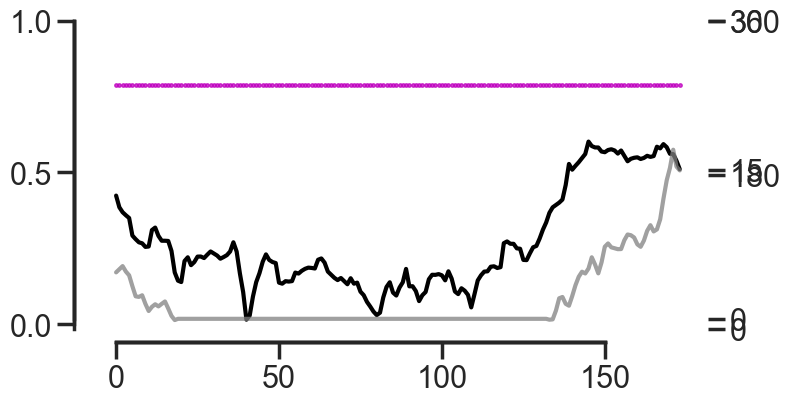

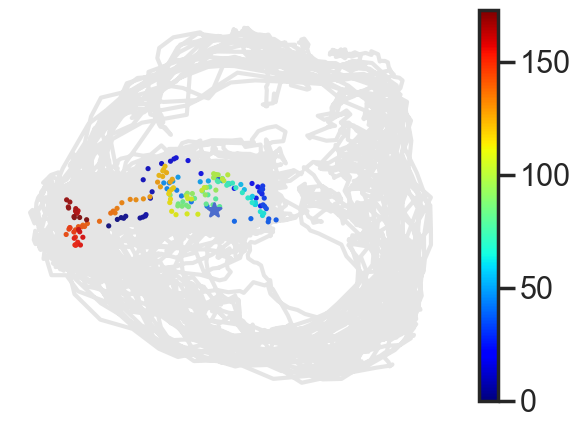

In [32]:
ls_pref, ls_nonpref, ls_rand = [], [], []
ls_df = []
pref_dir_thr = 45 
speed_thr = 5
ep_offset = 30
to_plot = True
# 25s
ep_end = 250

for k in df_emb_hdc.rec_id.unique():
    if 'TS7-HF' not in k:
        continue
    if '20220810_JA180' not in k:
        continue
    print(k)
    dts, mouse_id, hem, hstripe, cond, rec_session = get_recinfo_fname(k)
    if 'l' in hem:
        hem = 'left'
    else:
        hem = 'right'
    implant = mouse_id + '_' + hem
        
    tmp_df = df_emb_hdc[(df_emb_hdc.rec_id == k)]
    emb_x, emb_y = tmp_df['emb_x'].values, tmp_df['emb_y'].values
    lin_speed = tmp_df['lin_speed'].values
    stat_idx, run_idx = get_stat_run_epochs(lin_speed, window_size=5, speed_thr = speed_thr)
    # get stat epochs
    stat_epoch = consecutive(stat_idx)

    measured_yaw = tmp_df['measured_yaw'].values
    # compute off manifold ratios
    # _, rad_manifold = compute_radius(emb_x, emb_y)
    rad_manifold = tmp_df['rad_manifold'].values
    rad_manifold_norm = rad_manifold/rad_manifold.max()

    
    for ep_idx, ep in enumerate(stat_epoch):
        # at least 3s and no change in az
        if (len(ep) > 30):
            if ep_idx != 40:
                continue
            start, end = ep[0], ep[:][-1] + ep_offset
            if ep.size > 250:
                end = start + 250
            if rad_manifold_norm[ep[:ep_end]].min() < 0.3:
                offman_ep_flag = True
            else:
                continue
            if ep[0] - ep_offset < 1:
                continue
                
            angles = np.deg2rad(measured_yaw[ep[:ep_end]])
            circmean = stats.circmean(angles)
            circstd = stats.circstd(angles)
            circstd = np.deg2rad(circstd)
            this_yaw = np.rad2deg(circmean)
            if circstd > 1:
                continue
            print(f'{k}, ep idx: {ep_idx}, circmean {this_yaw}, circstd {circstd} min rad {rad_manifold_norm[ep[:ep_end]].min()}')
            print(f'len {len(ep)}, std: {round(np.std(measured_yaw[ep]), 2)}, idx: {start} - {end}')
            offset = rad_manifold_norm[start:end].argmin()
            
            if to_plot == True:
            
                f, ax = plt.subplots(1, figsize = (8, 4))
                ax.plot(rad_manifold_norm[start:end], color = 'k',)
                ax.set_yticks([0, 0.5, 1])
                ax_1 = ax.twinx()
                ax_1.plot( lin_speed[start:end],  color = 'gray', label = 'lin speed', alpha = 0.75)
                ax_1.set_yticks([0, 15, 30])
                ax_2 = ax.twinx()
                ax_2.plot( measured_yaw[start:end], 'm.', markersize = 5, label = 'yaw', alpha = 0.75)
                ax_2.set_yticks([0, 180, 360])
                sns.despine(offset = 10, trim = True)
                # plt.savefig(f'line_vel_{k}_{ep_idx}.pdf', transparent = True)
                time.sleep(0.2)
                
                f, ax = plt.subplots()
                x_tmp, y_tmp = emb_x[start:end], emb_y[start:end]
                u = np.diff(x_tmp)
                v = np.diff(y_tmp)
                pos_x = x_tmp[:-1] + u/2
                pos_y = y_tmp[:-1] + v/2
                norm = np.sqrt(u**2+v**2) 
                plt.plot(emb_x, emb_y, c = 'gray', alpha = 0.2)
                
                plt.scatter(x_tmp[:], y_tmp[:], alpha = 1, s = 3,  c = np.arange(0, end - start)[:x_tmp.size], 
                            cmap = 'jet')

                plt.colorbar()
    #             plt.quiver(pos_x[::10], pos_y[::10], (u/norm)[::10], (v/norm)[::10], angles="xy", 
    #                        zorder=5, pivot="mid", alpha = 0.5 )
                plt.scatter(emb_x[start + offset], emb_y[start + offset], c = 'k', s = 100, marker = "*")
                plt.axis('off')
                plt.savefig(f'scatter_isomap-traj_{k}_{ep_idx}.pdf', transparent = True)

    #             f.legend(loc='outside upper right')
                f.tight_layout()

                plt.show()


            print('')
            # break
    # break
# df_mandyn = pd.concat(ls_df)
# df_mandyn.head()

### Extract epochs

In [33]:
d_run_onset = {}

In [34]:
# Skip the epoch-based approach and work directly with continuous data
fs = 10  # Assuming 30 frames per second
speed_threshold = 5  # cm/s
radius_threshold = 0.1  # Relative change threshold
min_separation = fs


for k in df_emb_hdc.rec_id.unique():
    if 'TS7-HF' not in k:
        continue
    # if '20220804_JA179' not in k:
    #     continue
    print(k)
    d_run_onset[k] = {}
    
    dts, mouse_id, hem, hstripe, cond, rec_session = get_recinfo_fname(k)
    if 'l' in hem:
        hem = 'left'
    else:
        hem = 'right'
    implant = mouse_id + '_' + hem
        
    tmp_df = df_emb_hdc[(df_emb_hdc.rec_id == k)]
    emb_x, emb_y = tmp_df['emb_x'].values, tmp_df['emb_y'].values
    lin_speed = tmp_df['lin_speed'].values
    # stat_idx, run_idx = get_stat_run_epochs(lin_speed, window_size=5, speed_thr = speed_threshold)
    # get stat epochs
    # stat_epoch = consecutive(stat_idx)

    measured_yaw = tmp_df['measured_yaw'].values
    measured_yaw_rad = np.deg2rad(measured_yaw)
    # compute off manifold ratios
    # _, rad_manifold = compute_radius(emb_x, emb_y)
    rad_manifold = tmp_df['rad_manifold'].values
    rad_manifold_norm = rad_manifold/rad_manifold.max()
    
    # Find movement onset events with clean preceding stationary periods
    onset_events = []
    i = fs*3  # Start after first 3 seconds
    
    while i < len(lin_speed) - fs*3:  # Skip last 3 seconds
        # Check if this is a transition from stationary to moving
        if (np.mean(lin_speed[i-10:i]) < 2 and 
            np.mean(lin_speed[i:i+5]) > speed_threshold):
        
            # Stable heading
            # circmean = stats.circmean(measured_yaw_rad[i-5:i+10])
            circstd = stats.circstd(measured_yaw_rad[i-15:i+10])
            circstd = np.rad2deg(circstd)
            if circstd > 2:
                i += 1 
                continue
            
            
            # Find the precise frame where speed crosses threshold
            onset_frame = None
            for j in range(i-5, i+5):
                if lin_speed[j] > speed_threshold:
                    onset_frame = j
                    break
            
            if onset_frame is not None:
                onset_events.append(onset_frame)
                # Skip ahead to avoid double counting nearby transitions
                i = onset_frame + min_separation
                
            else:
                i += 1
        else:
            i += 1
    
    # For each onset event, extract a window of data
    pre_frames = 15  # 1.5 seconds before
    post_frames = 20  # 2 seconds after
    aligned_speed = []
    aligned_radius = []
    aligned_yaw = []
    for onset in onset_events:
        if onset > pre_frames and onset + post_frames < len(lin_speed):
            window = np.arange(onset - pre_frames, onset + post_frames)
            # choose epochs with off ring dynamics
            if rad_manifold_norm[window].min() > 0.3:
                continue
            aligned_speed.append(lin_speed[window])
            aligned_radius.append(rad_manifold_norm[window])
            aligned_yaw.append(measured_yaw[window])
            
    # Convert to arrays
    aligned_speed = np.array(aligned_speed)
    aligned_radius = np.array(aligned_radius)
    aligned_yaw = np.array(aligned_yaw)
    print(f'rec {k} shape {aligned_speed.shape}' )
    
    d_run_onset[k]['aligned_speed'] = aligned_speed
    d_run_onset[k]['aligned_radius'] = aligned_radius
    d_run_onset[k]['aligned_yaw'] = aligned_yaw
    
    # Calculate average traces
    # mean_speed = np.mean(aligned_speed, axis=0)
    # mean_radius = np.mean(aligned_radius, axis=0)
    # sem_speed = np.std(aligned_speed, axis=0) / np.sqrt(len(onset_events))
    # sem_radius = np.std(aligned_radius, axis=0) / np.sqrt(len(onset_events))

    # break

20220819_JA178_lADN_red_H2_VR1_TS7-HF
rec 20220819_JA178_lADN_red_H2_VR1_TS7-HF shape (8, 35)
20220823_JA178_lADN_red_H2_VR1_TS7-HF
rec 20220823_JA178_lADN_red_H2_VR1_TS7-HF shape (0,)
20220907_JA178_rADN_yel_H2_VR1_TS7-HF
rec 20220907_JA178_rADN_yel_H2_VR1_TS7-HF shape (0,)
20220802_JA179_lADN_red_H2_VR1_TS7-HF
rec 20220802_JA179_lADN_red_H2_VR1_TS7-HF shape (9, 35)
20220804_JA179_lADN_red_H2_VR1_TS7-HF
rec 20220804_JA179_lADN_red_H2_VR1_TS7-HF shape (8, 35)
20220805_JA179_lADN_red_H2_VR1_TS7-HF
rec 20220805_JA179_lADN_red_H2_VR1_TS7-HF shape (4, 35)
20220809_JA180_lADN_red_H2_VR1_TS7-HF
rec 20220809_JA180_lADN_red_H2_VR1_TS7-HF shape (4, 35)
20220810_JA180_lADN_red_H2_VR1_TS7-HF
rec 20220810_JA180_lADN_red_H2_VR1_TS7-HF shape (4, 35)
20220811_JA180_lADN_red_H2_VR1_TS7-HF
rec 20220811_JA180_lADN_red_H2_VR1_TS7-HF shape (14, 35)
20220819_JA180_lADN_red_H2_VR1_TS7-HF
rec 20220819_JA180_lADN_red_H2_VR1_TS7-HF shape (0,)
20220809_JA181_lADN_red_H2_VR1_TS7-HF
rec 20220809_JA181_lADN_red_H2

## Fig 4B

20220819_JA178_lADN_red_H2_VR1_TS7-HF
0
0.068 0.7
1
0.008 -0.5


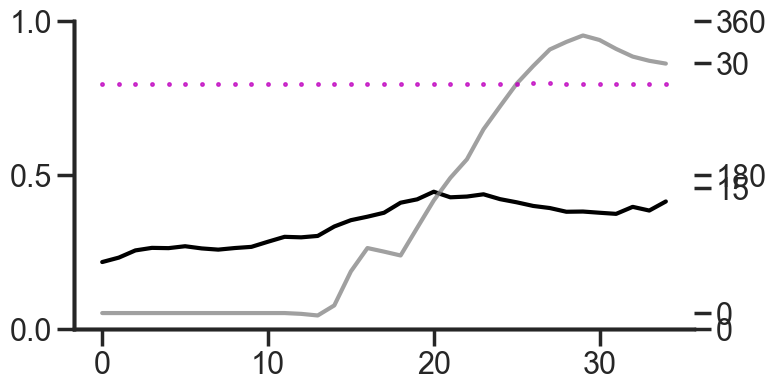

2
0.014 -0.1


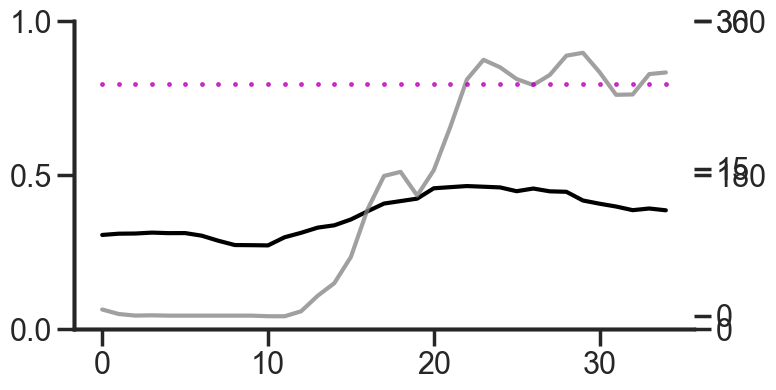

3
0.976 -1.7
4
0.928 -0.3
5
0.192 0.1
6
0.604 0.8
7
0.948 0.3
20220823_JA178_lADN_red_H2_VR1_TS7-HF
20220907_JA178_rADN_yel_H2_VR1_TS7-HF
20220802_JA179_lADN_red_H2_VR1_TS7-HF
0
0.246 -0.8
1
0.63 -0.5
2
0.724 -1.0
3
0.176 -0.4
4
0.332 -0.7
5
0.76 -0.2
6
0.032 0.1


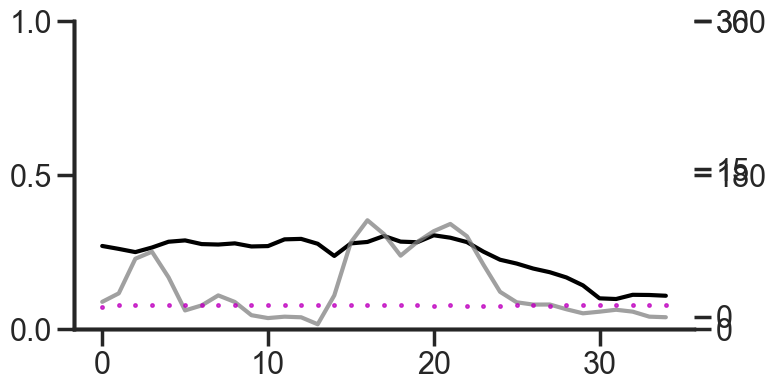

7
0.672 -0.2
8
0.006 -1.0


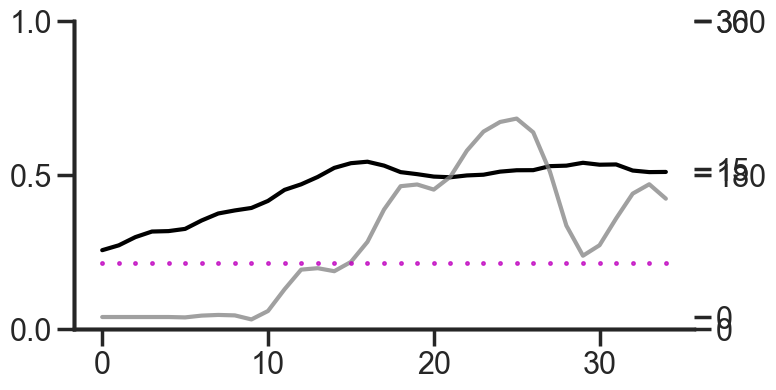

20220804_JA179_lADN_red_H2_VR1_TS7-HF
0
0.536 -2.0
1
0.0 -0.5


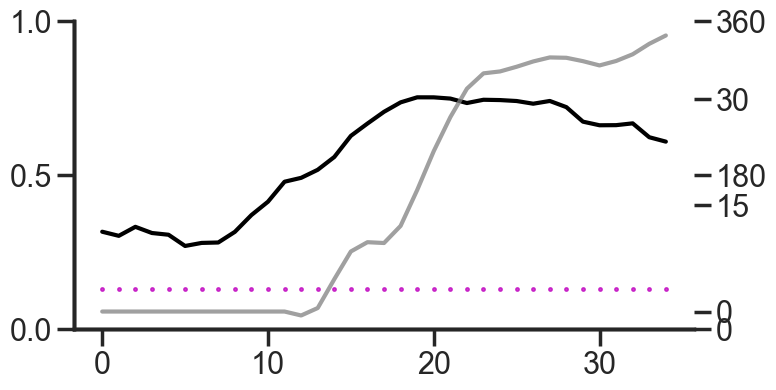

2
0.002 -0.5


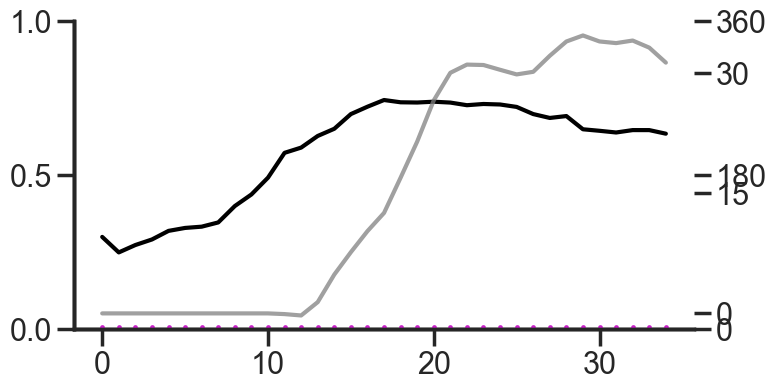

3
0.0 -1.1


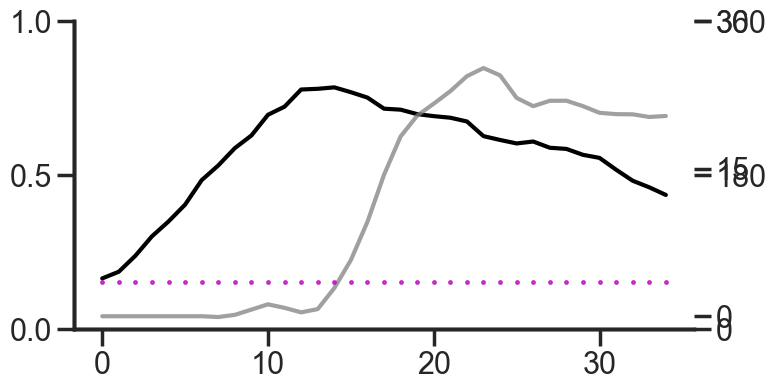

4
0.0 -0.6


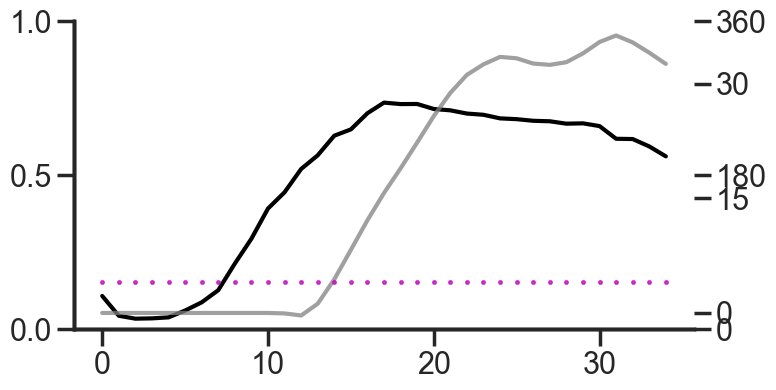

5
0.118 1.4
6
0.0 -0.7


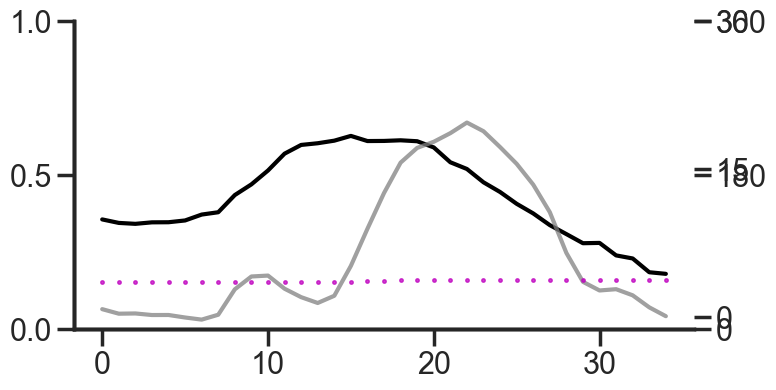

7
0.354 -0.3
20220805_JA179_lADN_red_H2_VR1_TS7-HF
0
0.016 0.6


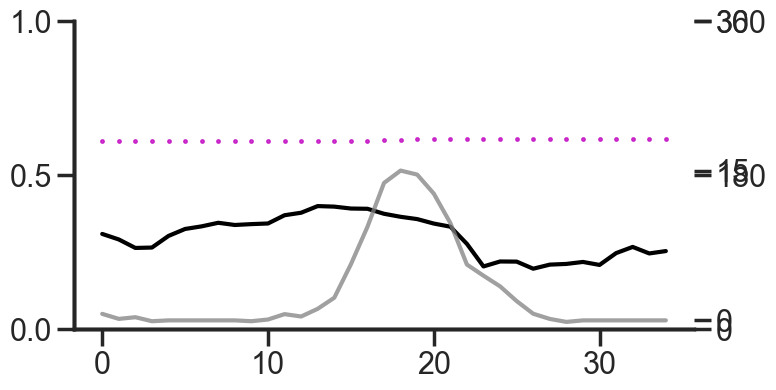

1
0.072 -0.3
2
0.006 -1.5


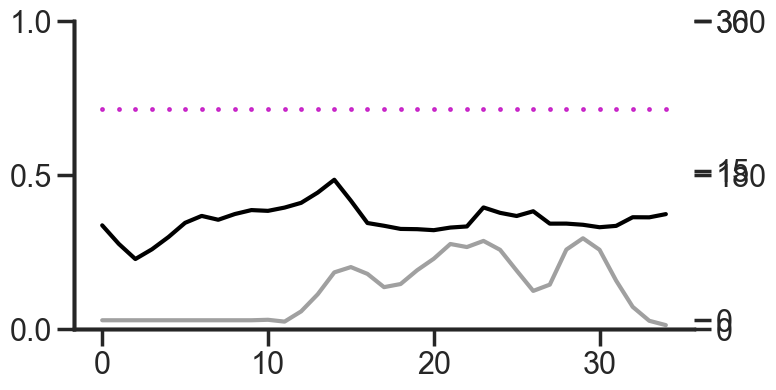

3
0.28 -1.6
20220809_JA180_lADN_red_H2_VR1_TS7-HF
0
0.422 0.4
1
0.01 0.1


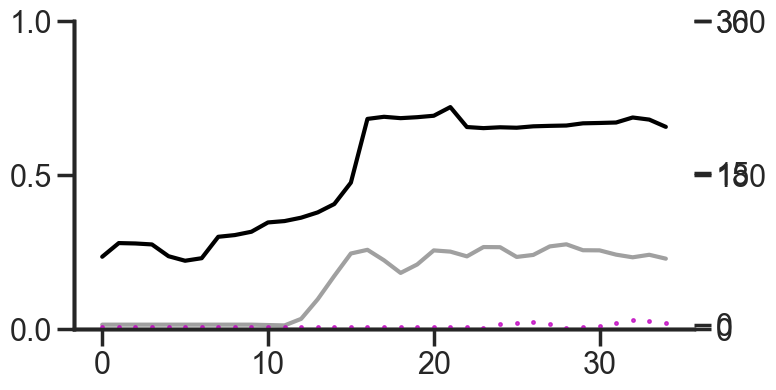

2
0.188 -1.2
3
0.608 -1.0
20220810_JA180_lADN_red_H2_VR1_TS7-HF
0
0.002 -0.4


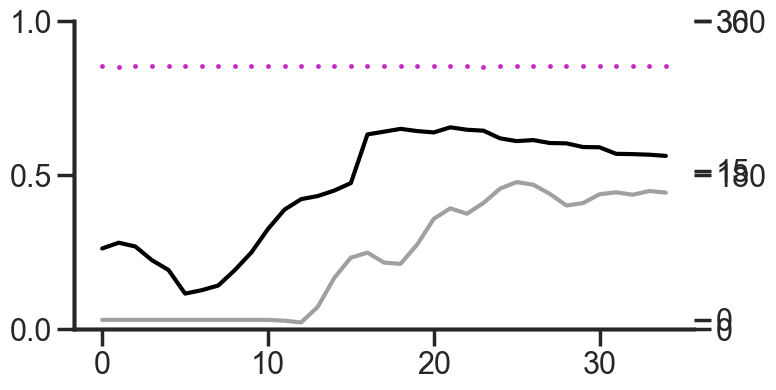

1
0.436 -1.1
2
0.54 -0.6
3
0.096 -1.7
20220811_JA180_lADN_red_H2_VR1_TS7-HF
0
0.002 -0.8


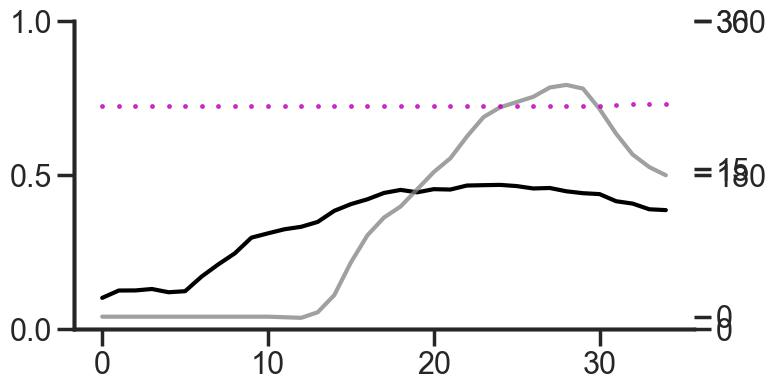

1
0.022 0.2


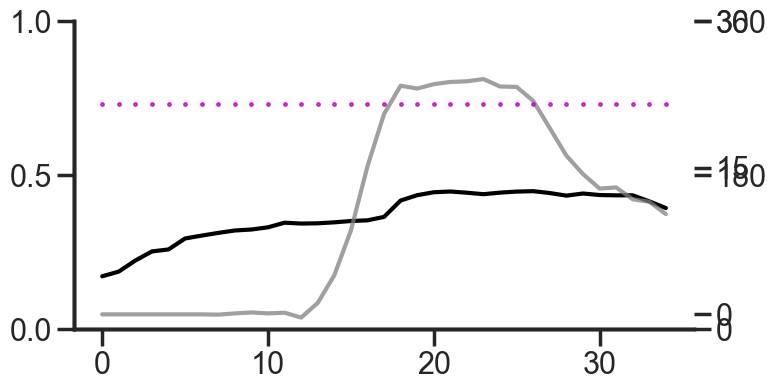

2
0.254 -0.9
3
0.022 -1.7


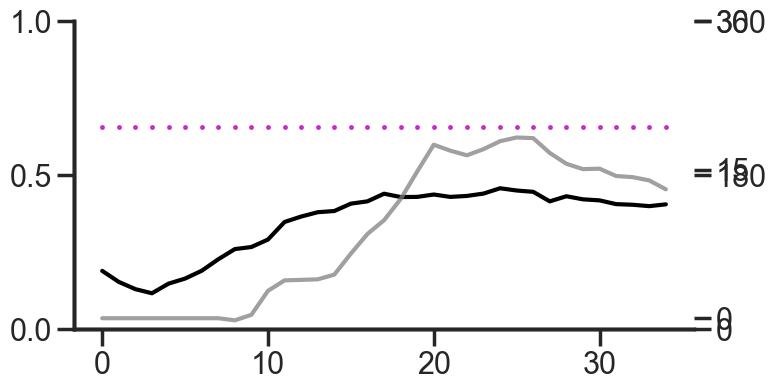

4
0.0 -0.8


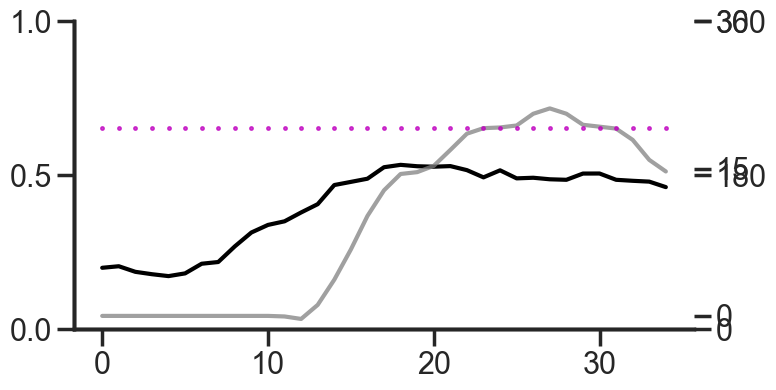

5
0.0 -0.4


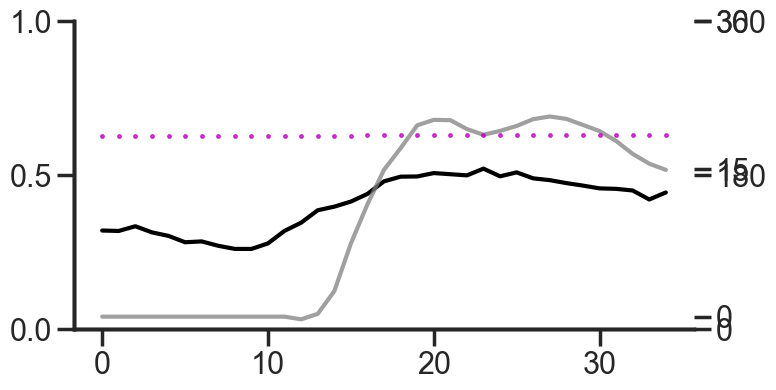

6
0.106 -0.3
7
0.002 -0.2


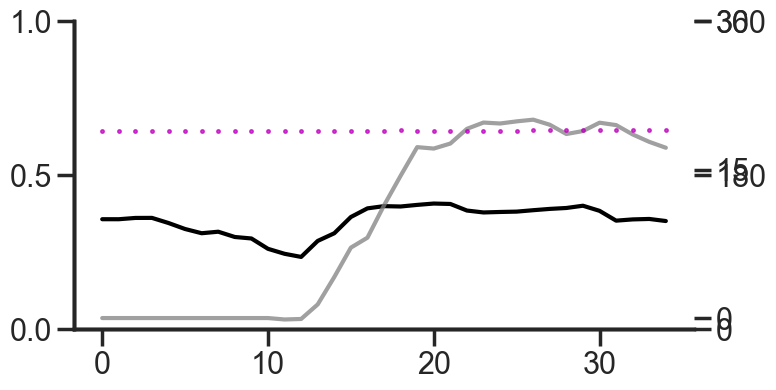

8
0.016 0.1


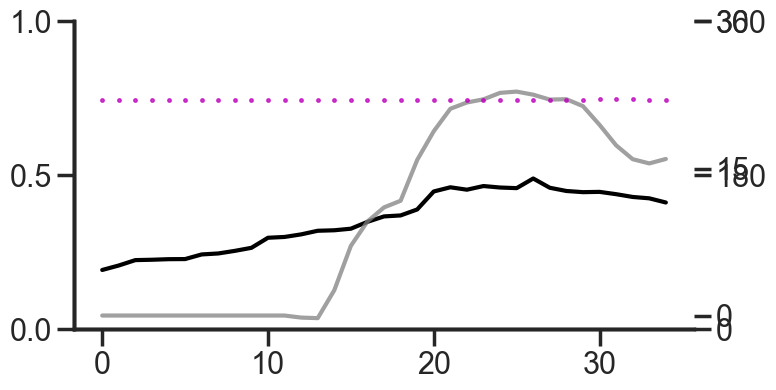

9
0.174 0.1
10
0.0 -0.5


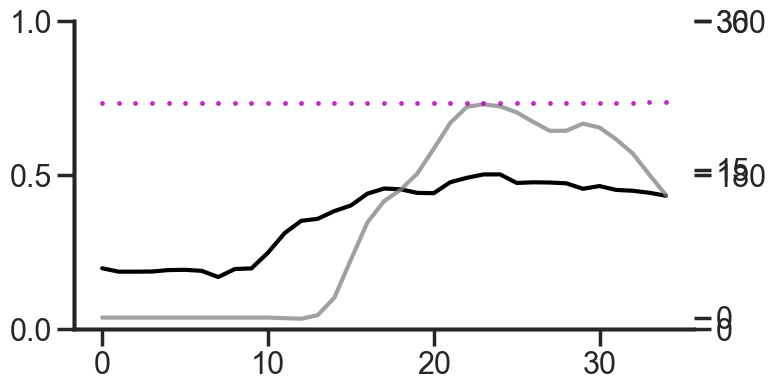

11
0.002 -0.6


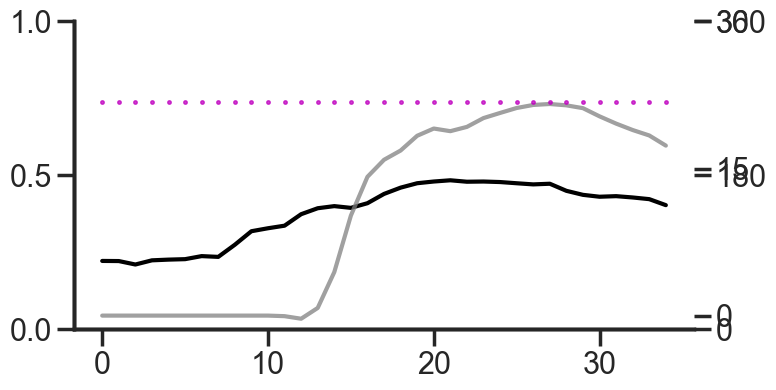

12
0.042 0.5


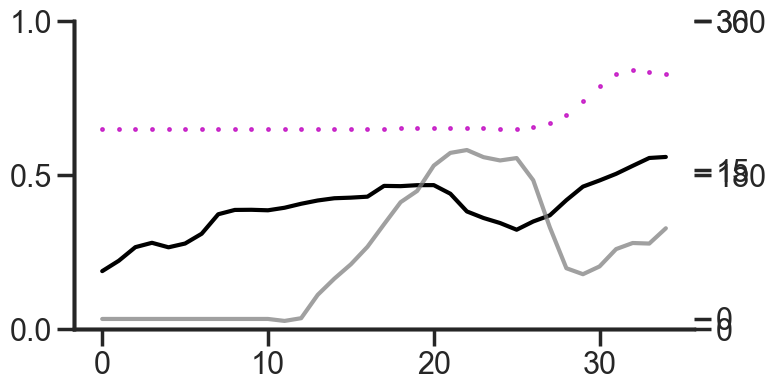

13
0.104 -0.8
20220819_JA180_lADN_red_H2_VR1_TS7-HF
20220809_JA181_lADN_red_H2_VR1_TS7-HF
0
0.016 -1.1


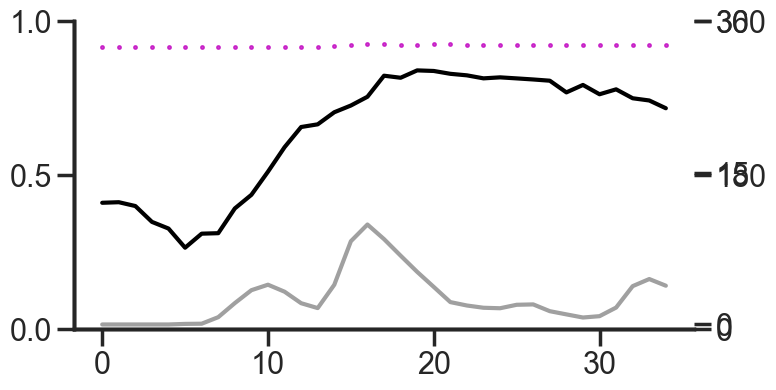

20220812_JA181_lADN_red_H2_VR1_TS7-HF
0
0.016 -1.5


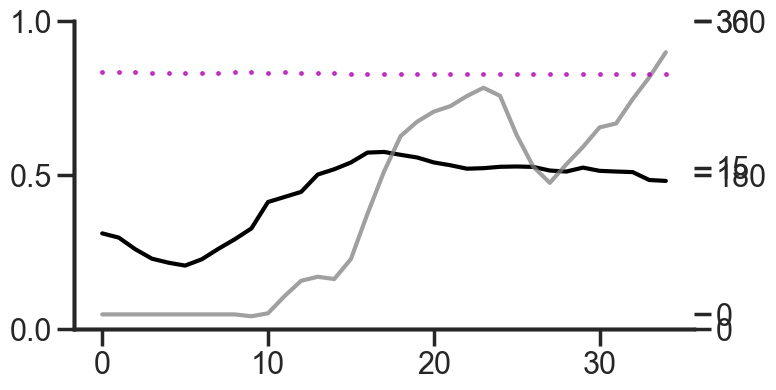

1
0.058 -0.5
20220627_MC022_lADN_red_H2_VR1_TS7-HF
0
0.526 -0.6
1
0.55 0.1
2
0.38 0.4
20220629_MC022_lADN_red_H2_VR1_TS7-HF
0
0.222 1.1
1
0.182 -2.3
2
0.0 -0.5


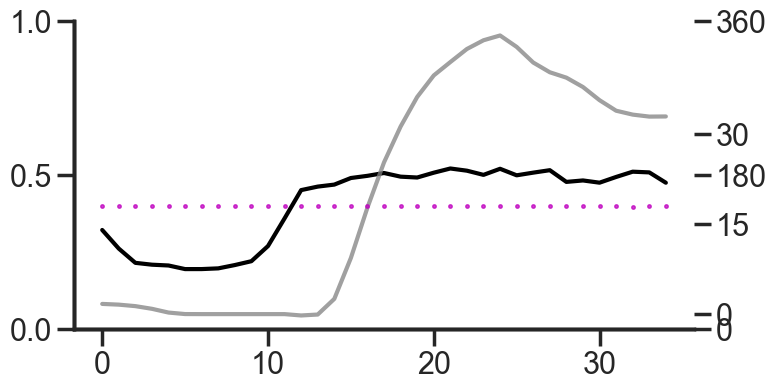

20220829_MC038_lADN_red_H2_VR1_TS7-HF
0
0.656 -2.3
1
0.134 0.1


,rec_id,epoch,aligned_speed,lag_s,xcorr_pval,lag,aligned_yaw,aligned_radius,time_idx
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,1,0.0,-0.5,0.008,-0.5,287.430167,0.218915,0
1,20220819_JA178_lADN_red_H2_VR1_TS7-HF,1,0.0,-0.5,0.008,-0.5,287.430110,0.233290,1
2,20220819_JA178_lADN_red_H2_VR1_TS7-HF,1,0.0,-0.5,0.008,-0.5,287.454461,0.256675,2
3,20220819_JA178_lADN_red_H2_VR1_TS7-HF,1,0.0,-0.5,0.008,-0.5,287.368597,0.264963,3
4,20220819_JA178_lADN_red_H2_VR1_TS7-HF,1,0.0,-0.5,0.008,-0.5,287.280151,0.264058,4


In [37]:
ls_lag = []
ls_df = []
time_idx = np.arange(35)
for k in d_run_onset.keys():
    print (k)
    aligned_speed = d_run_onset[k]['aligned_speed']
    aligned_yaw = d_run_onset[k]['aligned_yaw']
    aligned_radius = d_run_onset[k]['aligned_radius']
    if aligned_speed.shape[0] < 1:
        continue
    
    for idx, val in enumerate(aligned_speed[:]):
        print(idx)
        speed_diff = np.diff(aligned_speed[idx])
        radius_diff = np.diff(aligned_radius[idx])
        is_significant, p_value, lag_seconds = test_xcorr_significance(radius_diff, speed_diff, n_shuffles=500, fs=10, to_plot = False)
        # is_significant, p_value, lag_seconds = test_xcorr_significance(aligned_radius[idx], aligned_speed[idx], n_shuffles=500, fs=10, to_plot = False)
        print(p_value, lag_seconds)
        if p_value > 0.05:
            continue
            
        f, ax = plt.subplots(1, figsize = (8, 4))
        ax.plot(aligned_radius[idx], color = 'k',)
        ax.set_yticks([0, 0.5, 1])
        ax_1 = ax.twinx()
        ax_1.plot( aligned_speed[idx],  color = 'gray', label = 'lin speed', alpha = 0.75)
        ax_1.set_yticks([0, 15, 30])
        ax_2 = ax.twinx()
        ax_2.plot( aligned_yaw[idx], 'm.', markersize = 5, label = 'yaw', alpha = 0.75)
        ax_2.set_yticks([0, 180, 360])
        plt.show()
        
        ls_lag.append(lag_seconds)
        tmp_df = pd.DataFrame({'rec_id': k, 'epoch': idx, 'aligned_speed': aligned_speed[idx], 'lag_s':lag_seconds, 'xcorr_pval': p_value, 'lag': lag_seconds,
                              'aligned_yaw': aligned_yaw[idx], 'aligned_radius': aligned_radius[idx], 'time_idx':time_idx,
                              })
        ls_df.append(tmp_df)
    # break
df_run_onset = pd.concat(ls_df)
df_run_onset.head()

In [40]:
# df_run_onset[df_run_onset.time_idx == 0].groupby('rec_id').count()

# of epochs 26
mean -0.5153846153846153
median -0.5


(-1.5, 1.5)

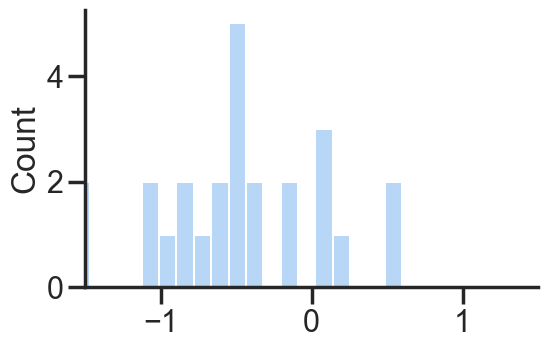

In [39]:
sns.displot(ls_lag, bins = 20,  height=4, aspect = 1.5)
print('# of epochs', len(ls_lag))
print('mean', np.mean(ls_lag))
print('median', np.median(ls_lag))
plt.xlim(-1.5, 1.5)
# plt.savefig(f'dist_vr_lag-rad_vel.pdf', transparent = True)

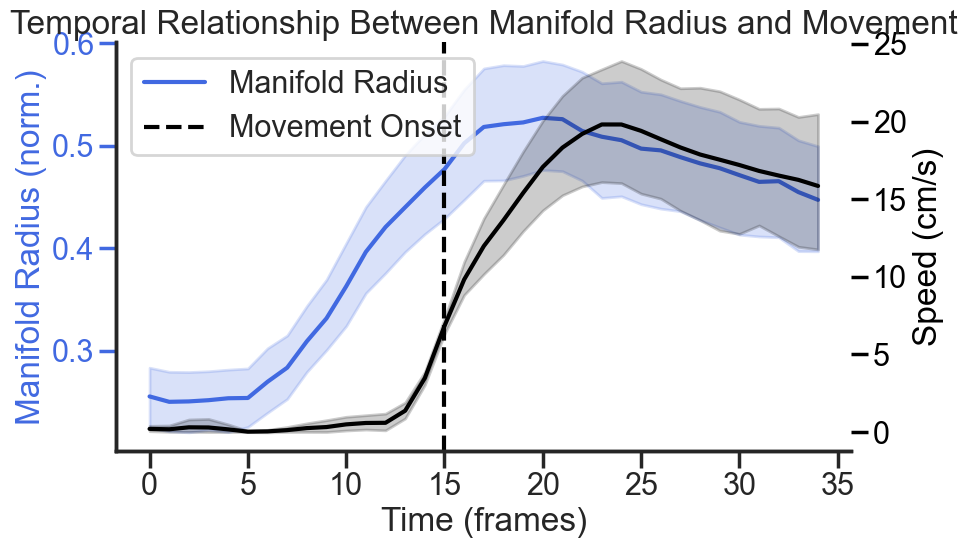

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 6))
_inp = df_run_onset
# Plot radius data on primary axis
sns.lineplot(
    data=_inp, 
    x='time_idx', 
    y='aligned_radius',
    ax=ax1,
    color='royalblue',
    label='Manifold Radius'
)
ax1.set_xlabel('Time (frames)')
ax1.set_ylabel('Manifold Radius (norm.)', color='royalblue')
ax1.tick_params(axis='y', colors='royalblue')

# Add a secondary y-axis for speed
ax2 = ax1.twinx()
sns.lineplot(
    data=_inp, 
    x='time_idx', 
    y='aligned_speed',
    ax=ax2,
    color='k',
    # label='Speed'
)
ax2.set_ylabel('Speed (cm/s)', color='k')
ax2.tick_params(axis='y', colors='k')

# Add vertical line at t=0 (movement onset)
ax1.axvline(x=15, color='black', linestyle='--', label='Movement Onset')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Temporal Relationship Between Manifold Radius and Movement')
plt.tight_layout()
# plt.savefig(f'line-vr_vel_rad.pdf', transparent = True)

0.0 -0.5


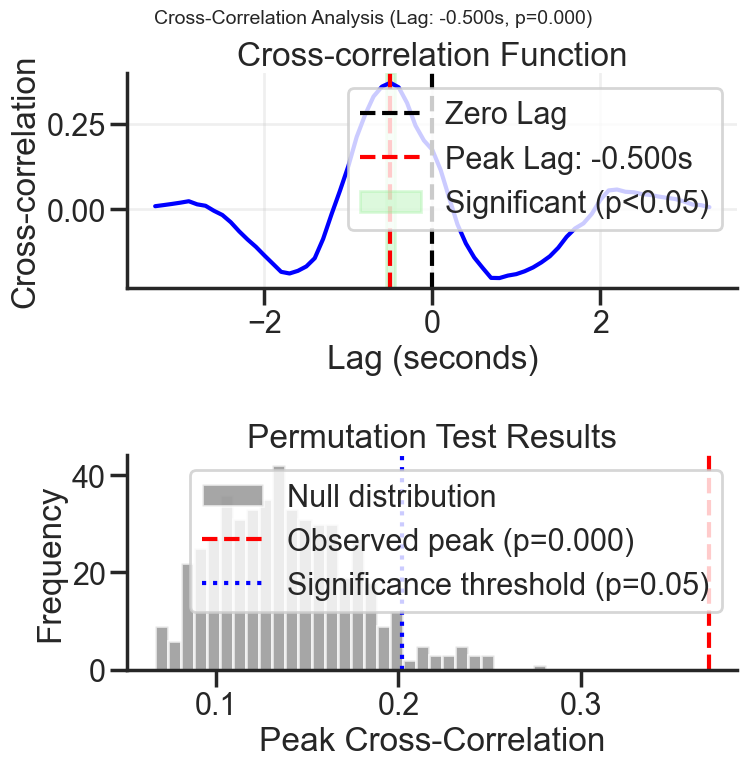

In [44]:
a = df_run_onset.groupby([ 'time_idx'])['aligned_speed'].mean()
b = df_run_onset.groupby([ 'time_idx'])['aligned_radius'].mean()
speed_diff = np.diff(a.values)
radius_diff = np.diff(b.values)
is_significant, p_value, lag_seconds = test_xcorr_significance(radius_diff, speed_diff, n_shuffles=500, fs=10, to_plot = True)
print(p_value, lag_seconds)
# plt.savefig(f'xcorr-vr_meanvel_rad.pdf', transparent = True)

## Fig 4C-D: HD manifold during stat, run, rot

20220819_JA178_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220823_JA178_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220907_JA178_rADN_yel_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220802_JA179_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220804_JA179_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220805_JA179_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220809_JA180_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220810_JA180_lADN_red_H2_VR1_TS7-HF


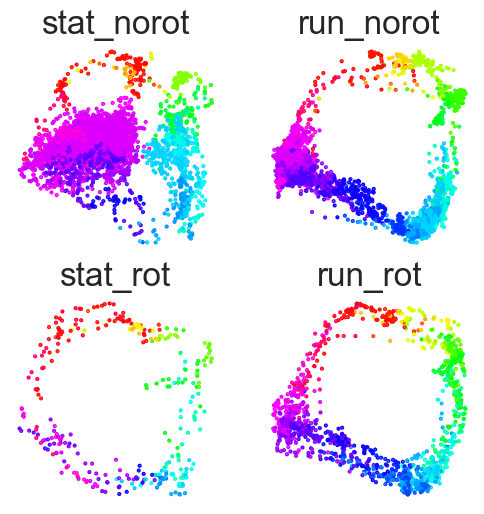

20220811_JA180_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220819_JA180_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220809_JA181_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220812_JA181_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220627_MC022_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220629_MC022_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

20220829_MC038_lADN_red_H2_VR1_TS7-HF


<Figure size 600x600 with 0 Axes>

,rec_id,cond,dts,mouse_id,omi,cond_az_occ,run_cond,h1bar,dec_err,rec_session,cond_ratio
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,TS7-HF,20220819,JA178,0.228049,0.500000,stat_norot,1.801161,24.911,JA178_20220819,0.307
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,TS7-HF,20220819,JA178,0.069595,0.833333,run_norot,31.456684,29.836,JA178_20220819,0.553
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,TS7-HF,20220819,JA178,0.184615,0.111111,stat_rot,1.110619,39.054,JA178_20220819,0.012
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,TS7-HF,20220819,JA178,0.100752,0.777778,run_rot,29.501816,29.225,JA178_20220819,0.124
0,20220823_JA178_lADN_red_H2_VR1_TS7-HF,TS7-HF,20220823,JA178,0.178512,0.722222,stat_norot,11.088336,22.541,JA178_20220823,0.119


In [12]:
ls_df = []
ls_beh_cond = ['stat_norot', 'run_norot', 'stat_rot',  'run_rot']
angles = np.arange(0, 380, 20)

for k in d_emb_ang.keys():
    if 'TS7-HF' not in k:
        continue
    print(k)
    dts, mouse_id, hem, hstripe, cond, rec_session = get_recinfo_fname(k)
    rec_session = mouse_id + '_' + dts
    
    tmp = d_emb_ang[k]
    isomap = tmp['isomap']
    measured_yaw = tmp['measured_yaw']
    isomap_yaw = tmp['isomap_yaw']
    lin_speed = tmp['lin_speed']
    run_rot = tmp['run_rot']['idx']
    # compute off manifold ratios
    _, rad_manifold = compute_radius(isomap[:,0], isomap[:,1])
    offmanifold_threshold = np.percentile(rad_manifold[run_rot], 10)
    
    fig = plt.figure(figsize=(6, 6))
    for idx, run_cond in enumerate(ls_beh_cond):
        cond_idx = d_emb_ang[k][run_cond]['idx']
        dec_err = d_emb_ang[k][run_cond]['dec_err']
        omi = np.sum(rad_manifold[cond_idx] < offmanifold_threshold)/rad_manifold[cond_idx].size 
        h0 = d_emb_ang[k][run_cond]['h0']
        h1 = d_emb_ang[k][run_cond]['h1']
        h2 = d_emb_ang[k][run_cond]['h2']
        h1bar = sorted(h1[:, 1] - h1[:, 0])[-1]
        cond_ratio = round(cond_idx.size/lin_speed.size, 3)
        occup, _ = np.histogram(measured_yaw[cond_idx], bins = angles)
        # at least 1s
        cond_az_occ = occup[occup > 10].size/occup.size
        # print(run_cond, omi)
        
        try:
#             h1bar = d_emb_ang[k][run_cond]['h1bar']
            to_plot, _ = get_long_bettibars(h0, h1, h2)
        except:
            continue

        tmp_df = pd.DataFrame({'rec_id': k, 'cond': cond, 'dts': dts, 'mouse_id': mouse_id, 'omi':omi,
                       'cond_az_occ':cond_az_occ, 'run_cond': run_cond, 'h1bar': h1bar, 'dec_err': dec_err, 
                       'rec_session':rec_session, 'cond_ratio': cond_ratio}, index = [0])
        ls_df.append(tmp_df)

        # rep example
        if k == '20220810_JA180_lADN_red_H2_VR1_TS7-HF':
            ax = fig.add_subplot(2, 2, idx + 1)
            
            ax.scatter(isomap[cond_idx, 0], isomap[cond_idx, 1], s = 1, c = measured_yaw[cond_idx], 
                                                   vmin = 0, vmax = 360, cmap = 'hsv')
            ax.axis('off')
            plt.xticks([])
            ax.set_title(run_cond)
    plt.show()
#         for curr_betti, curr_bar in enumerate(to_plot):
#             ax = fig.add_subplot(gs[curr_betti +3: curr_betti + 4, :3])
#             for i, interval in enumerate((curr_bar)):
#                 ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti], lw=3)
#             ax.set_xlim([-1, 40])
#             plt.xticks([])
#             plt.yticks([])
#         plt.show()
    # break
df_emb_ang = pd.concat(ls_df)
df_emb_ang.head()

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='run_cond', ylabel='omi'>

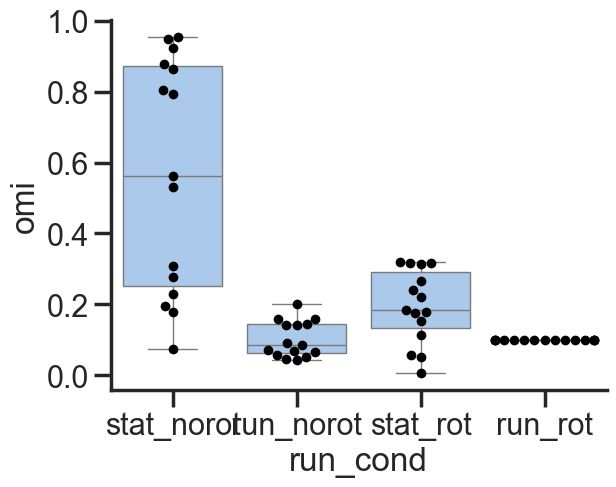

In [13]:
_inp_plot = df_emb_ang[(df_emb_ang.cond == 'TS7-HF')]
y = 'omi'
ls_beh_cond = ['stat_norot', 'run_norot', 'stat_rot',  'run_rot']

sns.boxplot(data = _inp_plot, x = 'run_cond', y = y, order = ls_beh_cond)
sns.swarmplot(data = _inp_plot, x = 'run_cond', y = y, size = 7, color = 'k', dodge = True, legend = False)

# plt.savefig(f'boxplot_{y}_lin-ang_vel.pdf', transparent = True)

In [14]:
_inp_plot.groupby('run_cond')[y].describe()

,count,mean,std,min,25%,50%,75%,max
run_cond,,,,,,,,
run_norot,15.0,0.102010,0.050933,0.043121,0.061779,0.085541,0.144158,0.201471
run_rot,15.0,0.100303,0.000277,0.100000,0.100000,0.100315,0.100490,0.100752
stat_norot,15.0,0.568194,0.328789,0.073973,0.253222,0.560879,0.871382,0.953791
stat_rot,15.0,0.194383,0.103961,0.006250,0.132440,0.184615,0.290909,0.319192


In [15]:
a1 = _inp_plot[_inp_plot.run_cond == 'stat_norot'][y]
a2 = _inp_plot[_inp_plot.run_cond == 'stat_rot'][y]
a3 = _inp_plot[_inp_plot.run_cond == 'run_norot'][y]
a4 = _inp_plot[_inp_plot.run_cond == 'run_rot'][y]

print(stats.kruskal(a1, a2, a3, a4))
print('stat vs run')
print(stats.mannwhitneyu(a1, a3))

print('stat vs rot')
print(stats.mannwhitneyu(a1, a2))

print('stat vs run_rot')
print(stats.mannwhitneyu(a1, a4))

KruskalResult(statistic=np.float64(28.99906588824021), pvalue=np.float64(2.2404413642718297e-06))
stat vs run
MannwhitneyuResult(statistic=np.float64(215.0), pvalue=np.float64(2.3290004782067238e-05))
stat vs rot
MannwhitneyuResult(statistic=np.float64(184.0), pvalue=np.float64(0.003230143595586664))
stat vs run_rot
MannwhitneyuResult(statistic=np.float64(210.0), pvalue=np.float64(5.522107927318715e-05))


## Fig 4E: Test various lin and ang vel thresholds

In [21]:
col_list = ['red', 'green', 'purple']
angles = np.arange(0, 380, 20)
h1_bar_max = 40
ls = []
lin_vel_thr = [1, 2, 4, 8]
ang_vel_thr = [5, 10, 20, 40]
ls_name = ['stat_norot', 'stat_rot', 'run_norot', 'run_rot']

for k in d_emb.keys():
    if 'LMK' in k:
        continue
    if 'TS7-HF' not in k:
        continue
    for lin_t in lin_vel_thr:
        for ang_t in ang_vel_thr:
            # print(lin_t, ang_t)
            start_time = time.time()
        
            dts, mouse_id, hem, hstripe, cond, rec_session = get_recinfo_fname(k)
            rec_session = mouse_id + '_' + dts
            tmp = d_emb[k]
            isomap = tmp['isomap']
            measured_yaw = tmp['measured_yaw']
            isomap_yaw, dec_err, _ = decode_az_isomap(isomap[:, 0], isomap[:, 1], measured_yaw[:])
            dyaw = compute_dYaw(measured_yaw)
            # sampling 10 Hz, 100ms
            ang_vel = dyaw*100
            lin_speed = tmp['lin_vel']
        
            # find stat, run, rot epochs
            try:
                stat_idx, run_idx = get_stat_run_epochs(lin_speed, window_size=5, speed_thr = lin_t)
                _, rot_idx = get_stat_run_epochs(ang_vel, window_size=5, speed_thr = ang_t)
            except:
                # print(k)
                continue
        
            # Finding unique elements
            stat_norot = np.setdiff1d(stat_idx, rot_idx)
            stat_rot = np.intersect1d(stat_idx, rot_idx)
            run_norot = np.setdiff1d(run_idx, rot_idx)
            run_rot = np.intersect1d(run_idx, rot_idx)
        
            if stat_norot.size < 5:
                # print(k)
                continue
            
            stat_ratio = stat_norot.size/lin_speed.size
            stat_rot_ratio = stat_rot.size/stat_idx.size
            run_rot_ratio = run_rot.size/run_idx.size
        
            run_ratio = run_idx.size/lin_speed.size
            # 50 samples = 5s
            occup, _ = np.histogram(measured_yaw[stat_idx], bins = angles)
            stat_az_occ = occup[occup > 10].size/occup.size
            occup, _ = np.histogram(measured_yaw[run_idx], bins = angles)
            run_az_occ = occup[occup > 10].size/occup.size
            # compute off manifold ratios
            _, rad_manifold = compute_radius(isomap[:,0], isomap[:,1])
            _, rad_manifold_stat = compute_radius(isomap[stat_norot,0], isomap[stat_norot,1])
            _, rad_manifold_loc = compute_radius(isomap[run_rot,0], isomap[run_rot,1])
        
            offmanifold_threshold = np.percentile(rad_manifold_loc, 10)
            stat_off_manifold = np.sum(rad_manifold_stat < offmanifold_threshold)/rad_manifold_stat.size
            
            tmp_df = pd.DataFrame({'rec_id': k, 'rec_session': rec_session, 'stat_ratio': stat_ratio,
                                  'lin_thr': lin_t, 'ang_thr':ang_t, 'stat_off_manifold':stat_off_manifold}, index = [0])
            ls.append(tmp_df)
            # print(f'{k}')
        
        #     f,ax = plt.subplots(2, 2, figsize = (6, 6))
        #     ax[0][0].scatter(isomap[stat_norot,0], isomap[stat_norot,1], s = 1, c = measured_yaw[stat_norot], 
        #                                            vmin = 0, vmax = 360, cmap = 'hsv')
        #     ax[0][0].axis('off')
        #     plt.xticks([])
        
        #     ax[0][1].scatter(isomap[stat_rot,0], isomap[stat_rot,1], s = 1, c = measured_yaw[stat_rot], 
        #                                            vmin = 0, vmax = 360, cmap = 'hsv')
        #     ax[0][1].axis('off')
        #     plt.xticks([])
        
        #     ax[1][0].scatter(isomap[run_norot,0], isomap[run_norot,1], s = 1, c = measured_yaw[run_norot], 
        #                                            vmin = 0, vmax = 360, cmap = 'hsv')
        #     ax[1][0].axis('off')
        #     plt.xticks([])
        
        #     ax[1][1].scatter(isomap[run_rot,0], isomap[run_rot,1], s = 1, c = measured_yaw[run_rot], 
        #                                            vmin = 0, vmax = 360, cmap = 'hsv')
        #     ax[1][1].axis('off')
        #     plt.xticks([])
        #     plt.show()
        
            # end_time = time.time()
            # print(end_time - start_time)
        # break
    
df_vel = pd.concat(ls)
df_vel.head()

,rec_id,rec_session,stat_ratio,lin_thr,ang_thr,stat_off_manifold
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,JA178_20220819,0.199065,1,5,0.518310
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,JA178_20220819,0.238318,1,10,0.316863
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,JA178_20220819,0.241121,1,20,0.309302
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,JA178_20220819,0.242056,1,40,0.359846
0,20220819_JA178_lADN_red_H2_VR1_TS7-HF,JA178_20220819,0.223364,2,5,0.449372


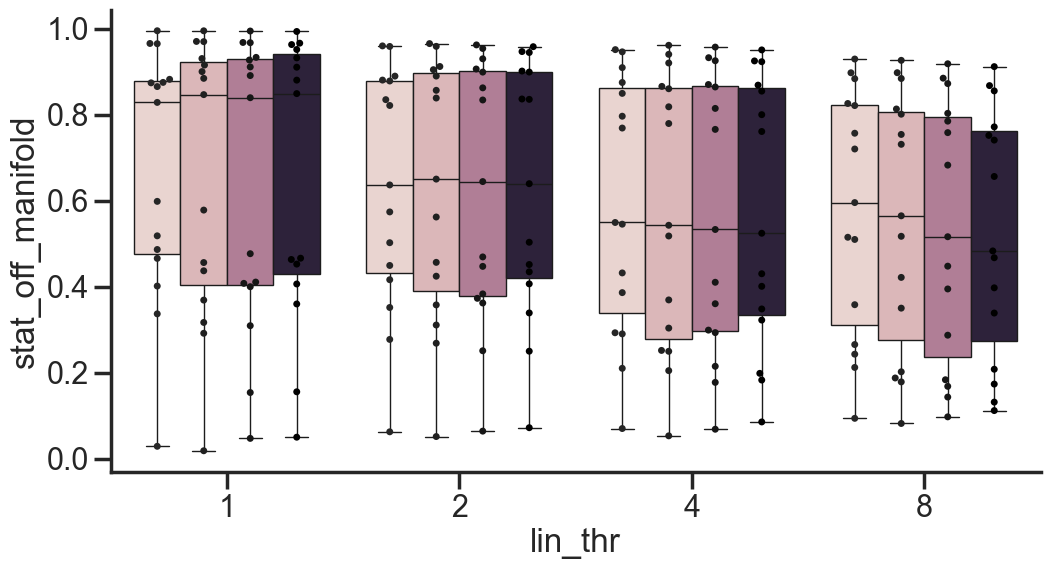

In [23]:
f, ax = plt.subplots(figsize = (12, 6))
_inp_plot = df_vel
y = 'stat_off_manifold'

sns.boxplot(data = _inp_plot, x = 'lin_thr', y = y, hue = 'ang_thr')
sns.swarmplot(data = _inp_plot, x = 'lin_thr', y = y,   hue = 'ang_thr', palette='dark:k', dodge = True, legend = False)
plt.legend().remove()  # This line removes the legend

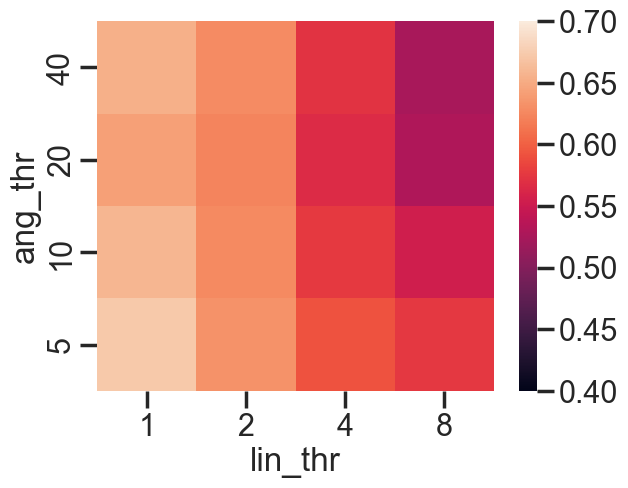

In [24]:
_inp_plot_2 = _inp_plot.groupby([ 'lin_thr', 'ang_thr'])[y].mean().reset_index()
_inp_plot_3 = _inp_plot_2.pivot(index = 'ang_thr', columns = 'lin_thr', values = 'stat_off_manifold')
ax = sns.heatmap(_inp_plot_3, vmin = 0.4, vmax  = 0.7, cmap = 'rocket')
ax.invert_yaxis()  # This line inverts the y-axis
plt.savefig(f'hetamap_offmanifold_lin-ang_vel.png', dpi = 300, transparent = True)
# plt.savefig(f'hetamap_offmanifold_lin-ang_vel.pdf', transparent = True)